# Задача 1

## Случайный вектор ${(\xi_1, \xi_2, \xi_3, \xi_4, \xi_5, \eta)}$ имеет компоненты, распределенные по следующему закону: ${\xi_k \sim R(-1, 1), \eta \sim N(2+3x_1-2x_2+x_3+x_4-x_5, 1.5^2)}$, где ${x_k}$ это значения, которые принимает случайная величина ${\xi_k}$. Сгенерировать выборку объема n = 50.

In [178]:
import random
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
from scipy.stats import t, f, norm
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.diagnostic import lilliefors

console = Console()
np.random.seed(2005)

n = 50
alpha = 0.05

xi_1 = np.random.uniform(-1.0, 1.0, n)
xi_2 = np.random.uniform(-1.0, 1.0, n)
xi_3 = np.random.uniform(-1.0, 1.0, n)
xi_4 = np.random.uniform(-1.0, 1.0, n)
xi_5 = np.random.uniform(-1.0, 1.0, n)

psi = np.array([xi_1, xi_2, xi_3, xi_4, xi_5]).transpose()
psi_transposed = psi.transpose()

Y = np.random.normal(
    loc=2 + 3 * xi_1 - 2 * xi_2 + xi_3 + xi_4 - xi_5, scale=1.5, size=n
)

## a) Проверить переменные  ${\xi_k}$ на мультиколлинеарность.

In [179]:
table = Table(show_header=True, header_style="green")
table.add_column("Переменная", justify="center")
table.add_column("R²", justify="center")
table.add_column("Независимость", justify="center")

for i in range(len(psi_transposed)):
    xi = psi_transposed[i]
    new_psi = []
    for j in range(len(psi_transposed)):
        if i != j:
            new_psi.append(psi_transposed[j])
    new_psi = np.array(new_psi).transpose()
    model = sm.OLS(xi, sm.add_constant(new_psi)).fit()
    table.add_row(f"ξ{i+1}", f"{model.rsquared:.3f}", f"{'Да' if model.rsquared < 0.7 else 'Нет'}")
    
console.print(table)

┏━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Переменная ┃  R²   ┃ Независимость ┃
┡━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━┩
│     ξ1     │ 0.042 │      Да       │
│     ξ2     │ 0.185 │      Да       │
│     ξ3     │ 0.071 │      Да       │
│     ξ4     │ 0.022 │      Да       │
│     ξ5     │ 0.163 │      Да       │
└────────────┴───────┴───────────────┘

### Отсюда можно сделать вывод, что все коэффициенты детерминации меньше 0.7, а значит мультиколлинеарность не наблюдается.

## b) Определить уравнение линейной регрессии ${\eta = \beta_0 + \sum\limits_{k=1}^{5} \beta_k \xi_k}$ и проверить значимость коэффициентов.

In [180]:
model = sm.OLS(Y, sm.add_constant(psi)).fit()
console.print(model.summary())

OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     18.38
Date:                Mon, 05 May 2025   Prob (F-statistic):           8.14e-10
Time:                        14:42:47   Log-Likelihood:                -92.460
No. Observations:                  50   AIC:                             196.9
Df Residuals:                      44   BIC:                             208.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2556      0.240      9.417      0.000       1.773       2.738
x1             2.4804      0.404      6.141      0.000       1.666       3.294
x2            -1.4489      0.447     -3.241      0.002      -2.350      -0.548
x3             1.2317      0.410      3.003      0.004       0.405       2.058
x4             1.5984      0.415      3.848      0.000       0.761       2.436
x5            -0.8704      0.399     -2.179      0.035      -1.675      -0.066
==============================================================================
Omnibus:                        1.058   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.589   Jarque-Bera (JB):                1.084
Skew:                           0.245   Prob(JB):                        0.582
Kurtosis:                       2.470   Cond. No.                         2.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [181]:
psi = sm.add_constant(psi)

F = np.dot(psi.transpose(), psi)
F_inverse = np.linalg.inv(F)

p = len(model.params)

table = Table(show_header=True, header_style="green")
table.add_column("Коэффициент", justify="center")
table.add_column("Значение", justify="center")
table.add_column("p-value", justify="center")
table.add_column("Значим/Незначим", justify="center")

for i, beta_i in enumerate(model.params):
    delta_wave = abs(beta_i / np.sqrt(model.ssr * F_inverse[i][i]) * np.sqrt(n - p))
    p_value = 2 * t.sf(delta_wave, n - p)
    table.add_row(f"β{i}", f"{beta_i}", f"{p_value}", f"{'Значим' if p_value < alpha else 'Незначим'}")

console.print(table)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Коэффициент ┃      Значение       ┃        p-value         ┃ Значим/Незначим ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│     β0      │  2.255604057158955  │  4.1185954359687e-12   │     Значим      │
│     β1      │ 2.4804279689909974  │ 2.0937503275683256e-07 │     Значим      │
│     β2      │ -1.4489208162165248 │ 0.0022704397212762605  │     Значим      │
│     β3      │ 1.2317425930099752  │  0.004392293361737991  │     Значим      │
│     β4      │ 1.5983972686432164  │ 0.0003810857945403662  │     Значим      │
│     β5      │ -0.8704250319849758 │   0.0346923450991037   │     Значим      │
└─────────────┴─────────────────────┴────────────────────────┴─────────────────┘

### Коэффициенты, у которых p-value меньше 0.05, являются значимыми, а у которых больше 0.05 - незначимыми.

## c) Определить коэффициент детерминации и проверить его значимость.

In [182]:
console.print(f"Коэффициент детерминации, R² = {model.rsquared}")

RSS = model.ssr
TSS = model.centered_tss

delta_wave = ((TSS - RSS) / (p - 1)) / (RSS / (n - p))
p_value = f.sf(delta_wave, p - 1, n - p) 

console.print(f"p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}")

Коэффициент детерминации, R² = 0.6762014954141751

p-value = 8.139192389466351e-10 < 0.05

### Мы видим, что p-value меньше 0.05, значит регрессия значима.

## d) Найти значение в точке ${x_k=0}$ и построить 95% доверительный интервал.

In [183]:
x_1, x_2, x_3, x_4, x_5 = 0, 0, 0, 0, 0

Y_k = np.random.normal(loc=2 + 3 * x_1 - 2 * x_2 + x_3 + x_4 - x_5, scale=1.5)

psi_0 = np.array([1, x_1, x_2, x_3, x_4, x_5]).transpose()

beta = 0.95

delta = (
    t.ppf((1 + beta) / 2, n - p)
    * np.sqrt(1 + np.dot(psi_0, np.dot(F_inverse, psi_0.transpose())))
    * np.sqrt(RSS / (n - p))
)

y_wave = np.dot(psi_0, model.params)

console.print(f"Δ = {delta}")
console.print(f"Доверительный интервал: ({y_wave - delta}, {y_wave + delta}), длина: {2 * delta}")

Δ = 3.338606140371789

Доверительный интервал: (-1.083002083212834, 5.594210197530744), длина: 6.677212280743578

## e) Проверить предположение о независимости ошибок измерения.

In [184]:
e = model.resid

In = 0

for i in range(len(e)):
    for j in range(i, len(e)):
        if e[i] > e[j]:
            In += 1

delta_wave = abs((In - (n * (n - 1)) / 4) / np.sqrt(n**3 / 36))

p_value = 2 * norm.sf(delta_wave)

console.print(f"p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}")

p-value = 0.640721345025641 > 0.05

### p-value получился больше 0.05, значит у нас нет оснований отвергать гипотезу случайности ошибок. Тоже самое, что и гипотеза о незавизимости ошибок измерения.

## f) Проверить предположение о нормальности распределения ошибок.

In [185]:
delta, p_value = lilliefors(e)

console.print(f'Δ = {delta}')
console.print(f'p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}')

Δ = 0.10189409464107807

p-value = 0.22024577321099162 > 0.05

### Так как p-value больше 0.05, то у нас нет оснований отвергать гипотезу.

## g) Исследовать регрессию на выбросы.

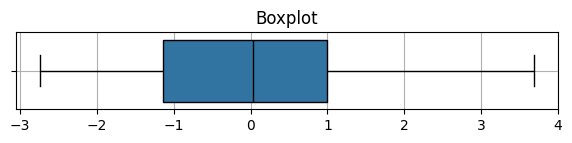

In [186]:
plt.figure(figsize=(7, 1))
sb.boxplot(x=e, linecolor="black")

plt.title("Boxplot")
plt.grid(True)
plt.show()

## h) Провести кросс-проверку регрессии.

In [187]:
CVSS = 0

for i in range(n):
    train_x = list(psi)
    test_x = train_x.pop(i)

    train_y = list(Y)
    test_y = train_y.pop(i)

    new_model = sm.OLS(train_y, train_x).fit()

    y_wave = new_model.params.dot(test_x)

    CVSS += (y_wave - test_y) ** 2

console.print(f"CVSS = {CVSS}")
console.print(f"Кросс-валидация: R² = {(model.centered_tss - CVSS) / model.centered_tss}")

CVSS = 150.08451941303198

Кросс-валидация: R² = 0.5889338069034656

## i) Проверить адекватность регрессии, сделав 5 повторных измерений в одной точке.

In [188]:
point = [1, 0, 0, 0, 0, 0]
l = 5

Y_l = np.random.normal(loc=2, scale=1.5, size=l)
Y_mean = np.mean(Y_l)

sigma_square_1_wave = 1 / (l - 1) * sum([(Y_l[i] - Y_mean) ** 2 for i in range(l)])

delta_wave = (RSS / (n - p)) / sigma_square_1_wave

p_value = f.sf(delta_wave, n - p, l - 1)

console.print(f"Δ = {delta_wave}")
console.print(f"p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}")

Δ = 2.6432981333407755

p-value = 0.17711387530316997 > 0.05

### Так как p-value больше 0.05, то у нас нет оснований отвергать гипотезу. Значит, модель адекватна.

## j) Удалить переменную, соответствующую наименее значимому коэффициенту и повторить пункты b и c, сравнить уравнения регрессии.

### В нашем случае наименее значимым является пятый коэффициент, так как у него наибольший p-value.

In [189]:
new_psi = np.array([xi_1, xi_2, xi_3, xi_4]).transpose()
new_psi = sm.add_constant(new_psi)

new_model = sm.OLS(Y, new_psi).fit()
console.print(new_model.summary())

OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     20.11
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.48e-09
Time:                        14:42:48   Log-Likelihood:                -95.023
No. Observations:                  50   AIC:                             200.0
Df Residuals:                      45   BIC:                             209.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2159      0.249      8.914      0.000       1.715       2.717
x1             2.3953      0.418      5.724      0.000       1.552       3.238
x2            -1.8150      0.431     -4.209      0.000      -2.683      -0.947
x3             1.3146      0.425      3.093      0.003       0.459       2.171
x4             1.6749      0.431      3.888      0.000       0.807       2.543
==============================================================================
Omnibus:                        1.201   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.548   Jarque-Bera (JB):                1.179
Skew:                           0.344   Prob(JB):                        0.555
Kurtosis:                       2.696   Cond. No.                         2.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [190]:
F = np.dot(new_psi.transpose(), new_psi)
F_inverse = np.linalg.inv(F)

p = len(new_model.params)

table = Table(show_header=True, header_style="green")

table.add_column("Коэффициент", justify="center")
table.add_column("Значение", justify="center")
table.add_column("p-value", justify="center")
table.add_column("Значим/Незначим", justify="center")

for i, beta_i in enumerate(new_model.params):
    delta_wave = abs(beta_i / np.sqrt(new_model.ssr * F_inverse[i][i]) * np.sqrt(n - p))
    p_value = 2 * t.sf(delta_wave, n - p)
    table.add_row(f"β{i}", f"{beta_i}", f"{p_value}", f"{'Значим' if p_value < alpha else 'Незначим'}")

console.print(table)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Коэффициент ┃      Значение       ┃        p-value         ┃ Значим/Незначим ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│     β0      │  2.215870461627834  │ 1.6758085064595705e-11 │     Значим      │
│     β1      │ 2.3952667406243964  │ 7.997000149728115e-07  │     Значим      │
│     β2      │ -1.8149657619787396 │ 0.00012087250341371483 │     Значим      │
│     β3      │  1.314640553158202  │  0.003398127851135826  │     Значим      │
│     β4      │ 1.6749061751529513  │ 0.00032995717583279155 │     Значим      │
└─────────────┴─────────────────────┴────────────────────────┴─────────────────┘

In [191]:
console.print(f"Коэффициент детерминации, R² = {new_model.rsquared}")

RSS = new_model.ssr
TSS = new_model.centered_tss

delta_wave = ((TSS - RSS) / (p - 1)) / (RSS / (n - p))
p_value = f.sf(delta_wave, p - 1, n - p)

console.print(f"p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}")

Коэффициент детерминации, R² = 0.6412451961112076

p-value = 1.483402213874132e-09 < 0.05

### Так как p-value меньше 0.05, то коэффициент детерминации значим.

In [192]:
RSS_0 = new_model.ssr
RSS_1 = model.ssr

p_0 = new_model.df_resid
p_1 = model.df_resid

delta = ((RSS_0 - RSS_1) * p_1) / (RSS_1 * (p_0 - p_1))

p_value = f.sf(delta, p_0 - p_1, p_1)

console.print(f"Δ = {delta}")
console.print(f"p-value = {p_value} {'>' if p_value > alpha else '<'} {alpha}")

Δ = 4.750105845293967

p-value = 0.03469234509910373 < 0.05

### Так как p-value меньше 0.05, то мы отвергаем гипотезу. Значит, регрессии не равны.

## k) Сравнить уравнения регрессии бутстрапом.

In [ ]:
N = 1000
beta = 0.95

h_wave = model.rsquared - new_model.rsquared

bootstrap_delta = []

for _ in range(N):
    subsample_psi = np.array(random.sample(list(psi), n))
    subsample_model = sm.OLS(Y, subsample_psi).fit()

    xi_0, xi_1, xi_2, xi_3, xi_4, xi_5 = subsample_psi.transpose()
    
    subsample_new_psi = np.array([xi_0, xi_1, xi_2, xi_3, xi_4]).transpose()
    subsample_new_model = sm.OLS(Y, subsample_new_psi).fit()

    bootstrap_delta.append(subsample_model.rsquared - subsample_new_model.rsquared - h_wave)

variation_row = sorted(bootstrap_delta)

delta_star_k = variation_row[int((1 - beta) * N)]

lower_bound = h_wave - variation_row[-1]
upper_bound = h_wave - delta_star_k

console.print(f'Доверительный интервал: ({lower_bound}, {upper_bound}), длина: {upper_bound - lower_bound}')

0.03495629930296751


Доверительный интервал: (-0.17916349678828425, 0.06979939311269812), длина: 0.24896288990098236

### Видно, что 0 принадлежит доверительному интервалу, а значит, что различие незначимо.